<a href="https://www.kaggle.com/code/owentamunogilbert/airline-price-prediction-by-awa?scriptVersionId=286230652" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<font size="+3"><b>Airline Price Prediction</font>

# Problem Case and MetaData

## Problem Case

> Most travel search engines do not have a variation of constraint for a traveller to know the price of their flights. However, many times the travelers' major constraint is their budget.
>
> Travellers might want to consider options for their flight based on their budgets, like what time of the day to fly, or how early should they book their flights, or if they can afford Business class for the distance they are travelling
>
> They want to know what they need to change to save cost or what is affordable with what they have
>

## Solution

> So basically, I'm building a machine learning model to perform prescriptive analysis on flight data, using counterfactual reasoning to simulate alternative booking scenarios and recommend optimal trade-offs between convenience and cost.

## Metadata


1) Airline: The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.
2) Flight: Flight stores information regarding the plane's flight code. It is a categorical feature.
3) Source City: City from which the flight takes off. It is a categorical feature having 6 unique cities.
4) Departure Time: This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.
5) Stops: A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.
6) Arrival Time: This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.
7) Destination City: City where the flight will land. It is a categorical feature having 6 unique cities.
8) Class: A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.
9) Duration: A continuous feature that displays the overall amount of time it takes to travel between cities in hours.
10)Days Left: This is a derived characteristic that is calculated by subtracting the trip date by the booking date.
11) Price: Target variable stores information of the ticket price.

# Importing Libraries

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math
import warnings

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact, VBox, HBox, Output, Layout, HTML

import plotly.express as px
import shap
import plotly.io as pio
import ipywidgets as widgets
import plotly.graph_objects as go
from IPython.display import display

warnings.filterwarnings('ignore')

ImportError: cannot import name 'root_mean_squared_error' from 'sklearn.metrics' (/usr/local/lib/python3.11/dist-packages/sklearn/metrics/__init__.py)

# Previewing the Data

In [2]:
df = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')

In [3]:
df_copy = df.drop(columns="Unnamed: 0").copy()

In [4]:
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [5]:
df.shape

(300153, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [7]:
df.describe()

,Unnamed: 0,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


In [8]:
for col in df.select_dtypes('object').columns:
    print(f'{col}: {df[col].nunique()} unique items')
    print(f'{df[col].unique()}')
    print('***')

airline: 6 unique items
['SpiceJet' 'AirAsia' 'Vistara' 'GO_FIRST' 'Indigo' 'Air_India']
***
flight: 1561 unique items
['SG-8709' 'SG-8157' 'I5-764' ... '6E-7127' '6E-7259' 'AI-433']
***
source_city: 6 unique items
['Delhi' 'Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai']
***
departure_time: 6 unique items
['Evening' 'Early_Morning' 'Morning' 'Afternoon' 'Night' 'Late_Night']
***
stops: 3 unique items
['zero' 'one' 'two_or_more']
***
arrival_time: 6 unique items
['Night' 'Morning' 'Early_Morning' 'Afternoon' 'Evening' 'Late_Night']
***
destination_city: 6 unique items
['Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai' 'Delhi']
***
class: 2 unique items
['Economy' 'Business']
***


# Data Cleaning and Preparation

In [9]:
df['route'] = df['source_city']+" - "+df['destination_city']

In [10]:
df['trip_time'] = df['departure_time']+" - "+df['arrival_time']

In [11]:
df.drop(columns=['Unnamed: 0', 'source_city', 'destination_city', 'departure_time', 'arrival_time','flight'], inplace=True)

In [12]:
df.isna().sum()

airline      0
stops        0
class        0
duration     0
days_left    0
price        0
route        0
trip_time    0
dtype: int64

In [13]:
for col in df.select_dtypes('object').columns:
    print(col)
    print(df[col].unique())

airline
['SpiceJet' 'AirAsia' 'Vistara' 'GO_FIRST' 'Indigo' 'Air_India']
stops
['zero' 'one' 'two_or_more']
class
['Economy' 'Business']
route
['Delhi - Mumbai' 'Delhi - Bangalore' 'Delhi - Kolkata'
 'Delhi - Hyderabad' 'Delhi - Chennai' 'Mumbai - Delhi'
 'Mumbai - Bangalore' 'Mumbai - Kolkata' 'Mumbai - Hyderabad'
 'Mumbai - Chennai' 'Bangalore - Delhi' 'Bangalore - Mumbai'
 'Bangalore - Kolkata' 'Bangalore - Hyderabad' 'Bangalore - Chennai'
 'Kolkata - Delhi' 'Kolkata - Mumbai' 'Kolkata - Bangalore'
 'Kolkata - Hyderabad' 'Kolkata - Chennai' 'Hyderabad - Delhi'
 'Hyderabad - Mumbai' 'Hyderabad - Bangalore' 'Hyderabad - Kolkata'
 'Hyderabad - Chennai' 'Chennai - Delhi' 'Chennai - Mumbai'
 'Chennai - Bangalore' 'Chennai - Kolkata' 'Chennai - Hyderabad']
trip_time
['Evening - Night' 'Early_Morning - Morning'
 'Early_Morning - Early_Morning' 'Morning - Afternoon' 'Morning - Morning'
 'Afternoon - Evening' 'Evening - Early_Morning' 'Evening - Morning'
 'Early_Morning - Evening' 'Early_Mor

# Visualization

In [14]:
plt.rcParams.update({'axes.labelweight':'bold', 'axes.labelcolor':'blue','legend.edgecolor':"brown",'xtick.color':'blue',
                     'ytick.color':'blue',
                    'axes.grid':True,'grid.color':'#BFBFBF','grid.linestyle':'--','axes.edgecolor':'blue',
                    'axes.titlecolor':"blue",'axes.titleweight':'bold','figure.facecolor':'lightgray'})


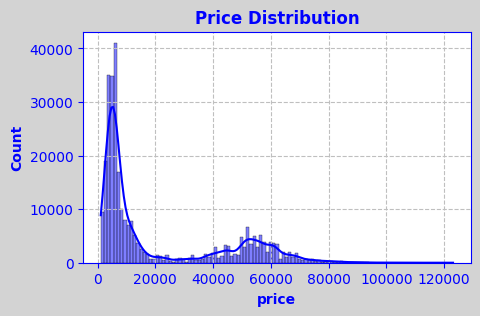

In [15]:
plt.figure(figsize=(5,3))
sns.histplot(df['price'], kde=True,color='blue')
plt.title('Price Distribution')
plt.show()

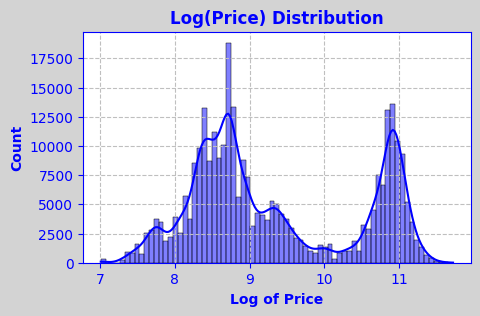

In [16]:
plt.figure(figsize=(5,3))
sns.histplot(np.log1p(df['price']), kde=True,color='blue')
plt.title('Log(Price) Distribution')
plt.xlabel('Log of Price')
plt.show()

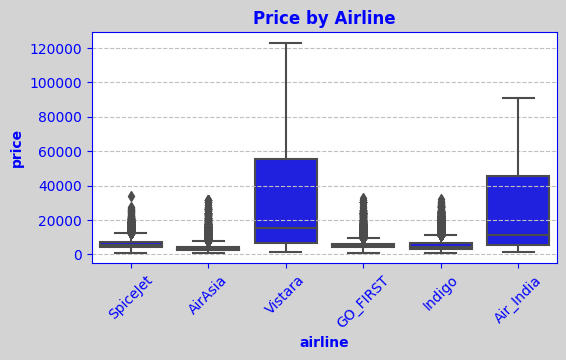

In [17]:
plt.figure(figsize=(6,3))
sns.boxplot(data=df, x='airline', y='price',color='blue')
plt.xticks(rotation=45)
plt.title('Price by Airline')
plt.show()

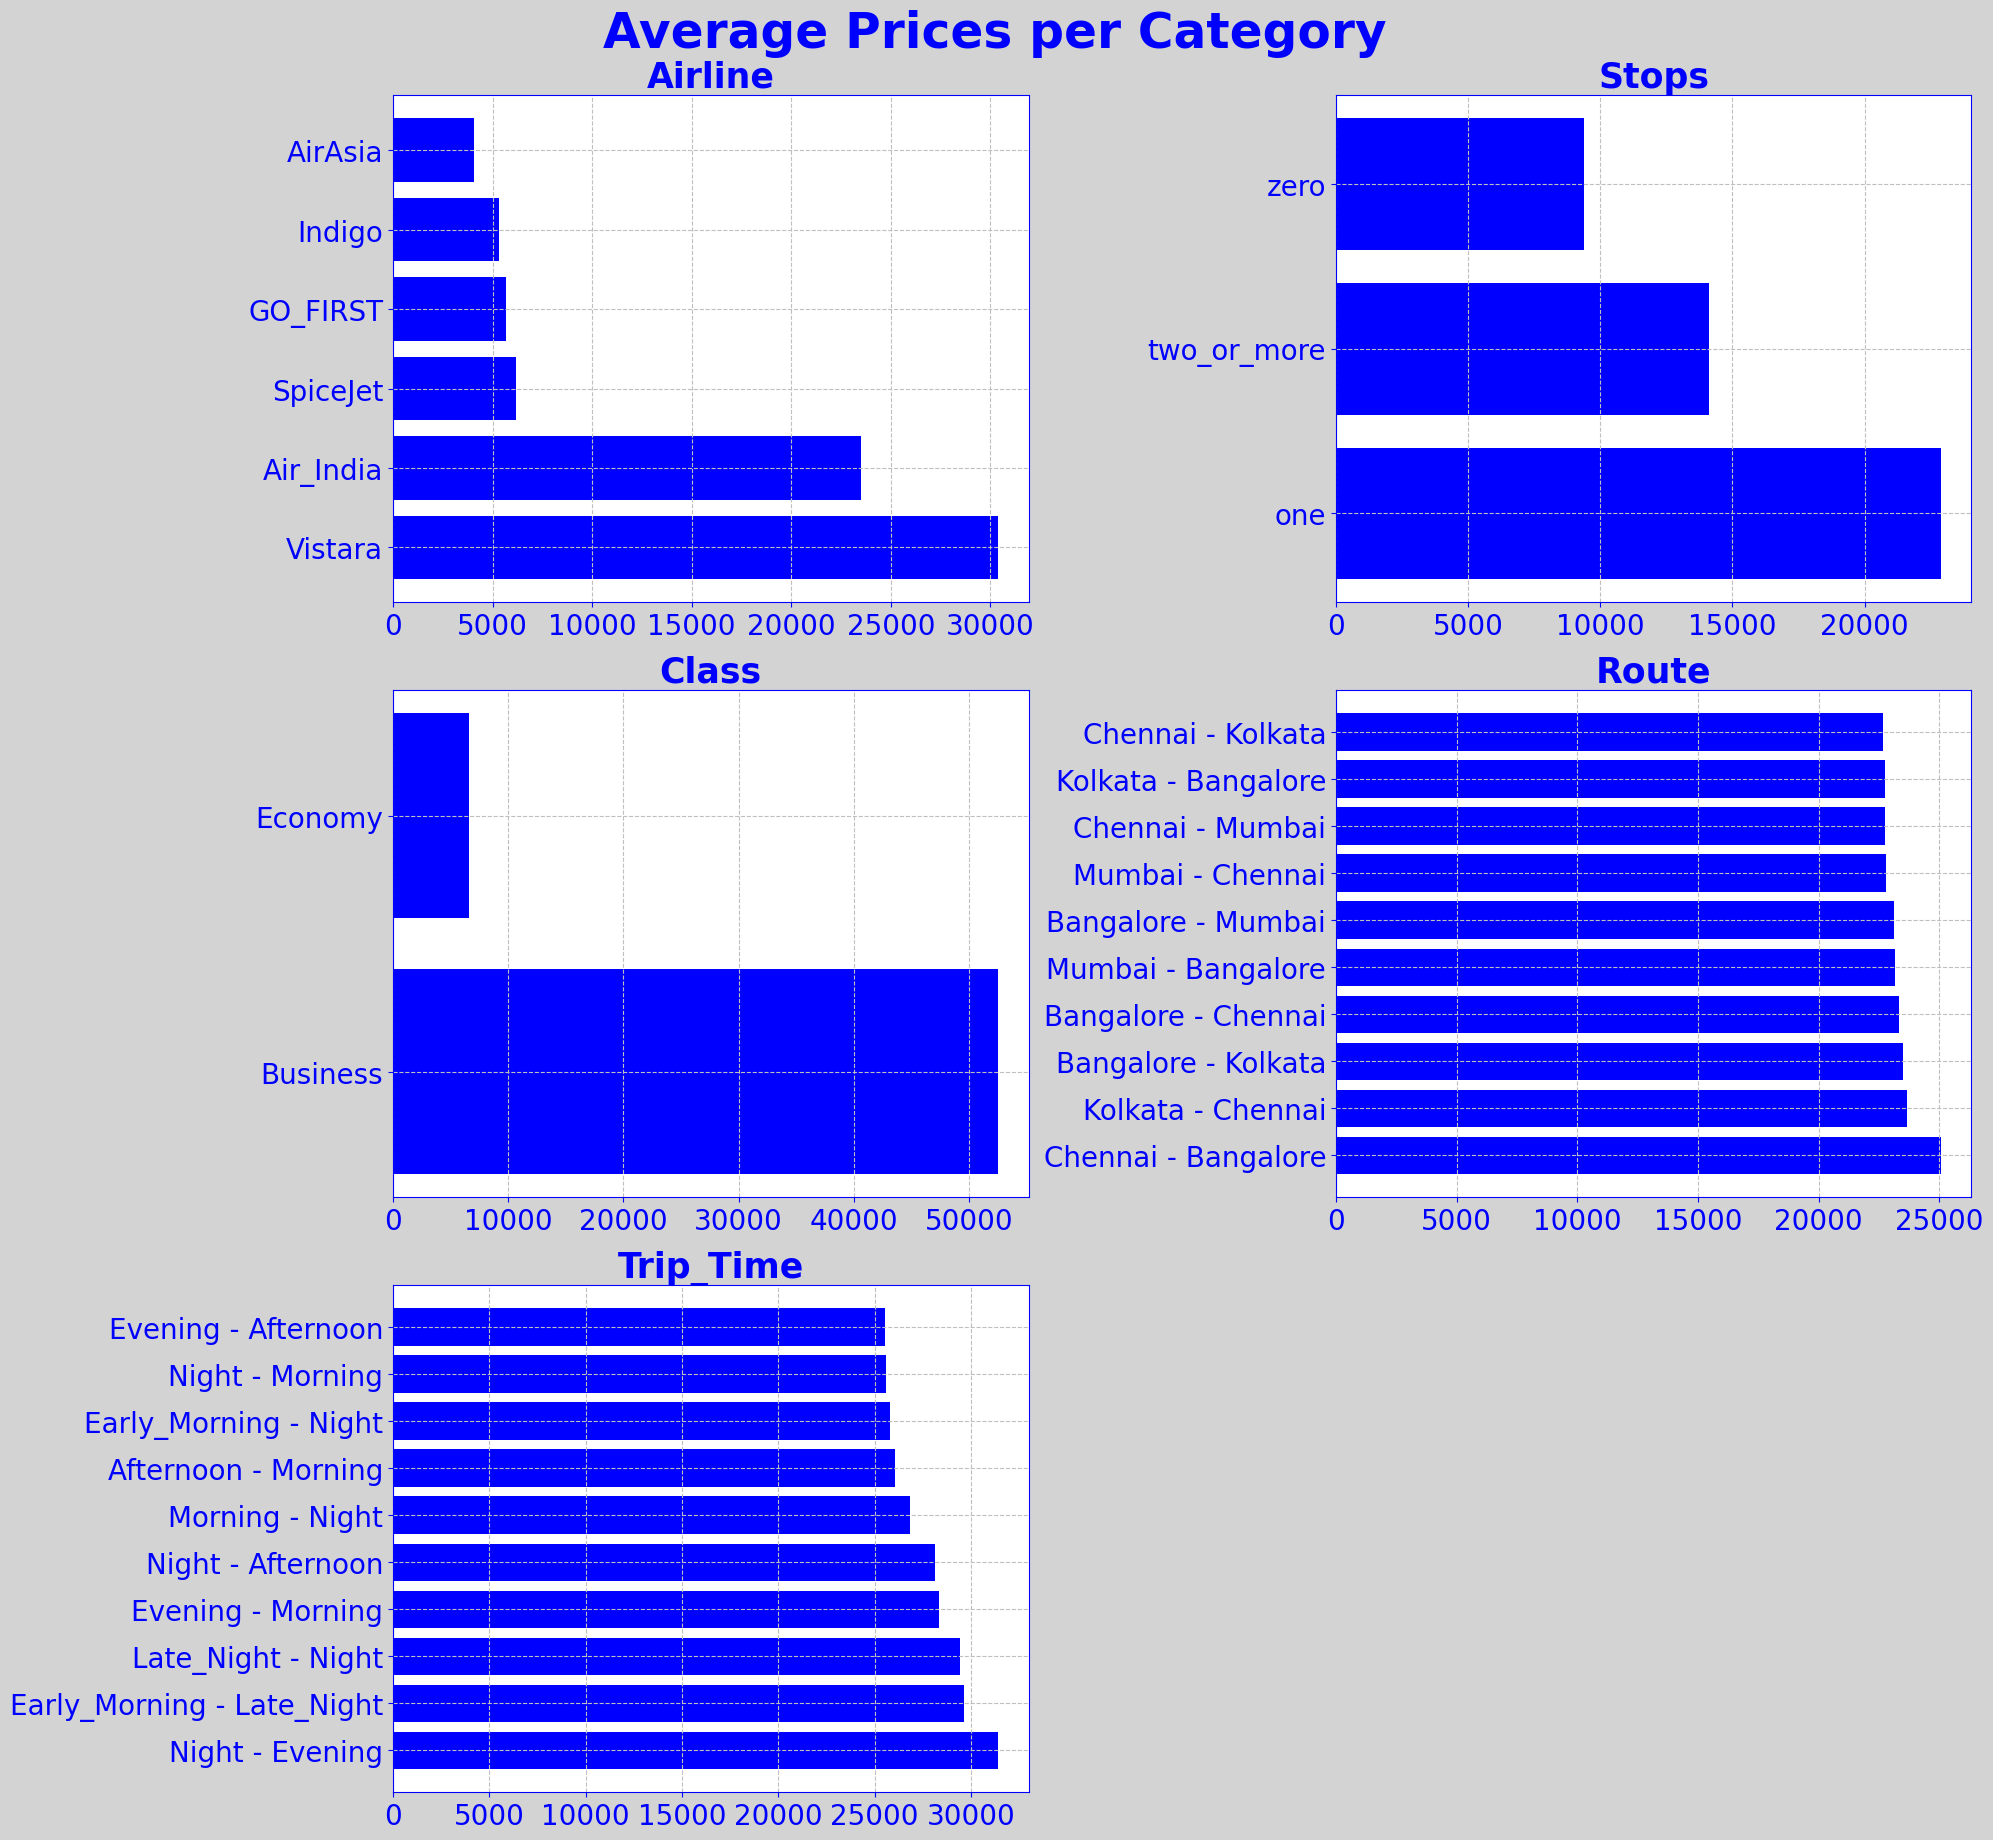

In [18]:
plot_cols = [col for col in df.select_dtypes('object').columns if col != 'flight']
avg_per_col = {col: df.groupby(col)['price'].mean().sort_values(ascending=False).head(10) for col in plot_cols}

ncols=2
nrows=math.ceil(len(plot_cols)/ncols)

fig, axes = plt.subplots(nrows,ncols,figsize=(20,6*nrows))
axes = axes.flatten()

for ax, col in zip(axes,plot_cols):
    avgcol = avg_per_col[col]
    labels = avgcol.index.tolist()

    ax.barh(avgcol.index,avgcol.values, color='blue')
    ax.set_title(col.title(),fontsize=25)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelsize=20)

for i in range(len(plot_cols),len(axes)):
    plt.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Average Prices per Category', size=35, weight='bold',y=1.02, color='blue')
plt.show()

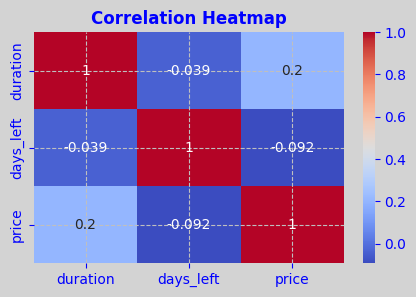

In [19]:
plt.figure(figsize=(5,3))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Feature Engineering

In [20]:
x = df.drop(columns=['price'])
y = df['price']

# Machine Learning

In [21]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,train_size=0.7,random_state=1)

In [22]:
ord_cols = ['stops', 'class']
targ_cols = ["route", "trip_time"]
ohe_cols = ["airline",]

In [23]:
preprocess = ColumnTransformer([
    ('ordinal',OrdinalEncoder(categories=[
        ["zero","one","two_or_more"],
        ["Economy","Business"]]),ord_cols),
    ('target',TargetEncoder(smoothing=1.0),targ_cols),
    ('ohe',OneHotEncoder(),ohe_cols)
],remainder='passthrough',verbose_feature_names_out=False)

In [24]:
pipe = Pipeline([('preprocess',preprocess),
                  ('model',XGBRegressor())])

In [25]:
param_grid = {
    'model__n_estimators': [100, 500, 1000],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7, 10],
    'model__subsample': [0.7, 0.9, 1.0]
}

In [26]:
search = RandomizedSearchCV(
    pipe, param_grid,
    cv=3, n_jobs=-1,
    scoring="r2", return_train_score=True,
    verbose=1,random_state=42
)

In [27]:
search.fit(xtrain,np.log1p(ytrain))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinal',
                                                                               OrdinalEncoder(categories=[['zero',
                                                                                                           'one',
                                                                                                           'two_or_more'],
                                                                                                          ['Economy',
                                                                                                           'Business']]),
                                                                               ['stops',
                                                                                'class']),
                                                                              ('target',
                                                                               TargetEncoder(smoothing=1.0),
                                                                               ['route',
                                                                                'trip_time']),
                                                                              ('ohe',
                                                                               OneHotEncoder(),
                                                                               ['airline'])],
                                                                verbose_feature_name...
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]),
                   n_jobs=-1,
                   param_distributions={'model__learning_rate': [0.01, 0.05,
                                                                 0.1],
                                        'model__max_depth': [3, 5, 7, 10],
                                        'model__n_estimators': [100, 500, 1000],
                                        'model__subsample': [0.7, 0.9, 1.0]},
                   random_state=42, return_train_score=True, scoring='r2',
                   verbose=1)

In [28]:
print(f"Best Parameters: {search.best_params_}")
print(f"\nBest Score: {search.best_score_}")

Best Parameters: {'model__subsample': 0.9, 'model__n_estimators': 500, 'model__max_depth': 10, 'model__learning_rate': 0.05}

Best Score: 0.9827079291853873


In [29]:
model = search.best_estimator_

In [30]:
model.fit(xtrain,np.log1p(ytrain))

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['zero',
                                                                              'one',
                                                                              'two_or_more'],
                                                                             ['Economy',
                                                                              'Business']]),
                                                  ['stops', 'class']),
                                                 ('target',
                                                  TargetEncoder(smoothing=1.0),
                                                  ['route', 'trip_time']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['airline'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 XGBRegresso...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [31]:
log_ypred = model.predict(xtest)
actual_pred = np.expm1(log_ypred)

In [32]:
acc_score = model.score(xtrain,np.log1p(ytrain))
acc_score

0.9894789493457236

In [33]:
r2_score(ytest, )

0.9852340953237374

In [47]:
print(f"R2 Score: {r2_score(ytest, actual_pred)}")
print(f"On average our predictions are off by ₹{np.sqrt(mean_squared_error(ytest, actual_pred)):.2f}")


R2 Score: 0.9852340953237374
On average our predictions are off by ₹2753.88


> Our Model has a very high train accuracy and does not overfit

# Interactive Dashboard

In [34]:
orig_x_num = [col for col in df_copy.select_dtypes('number').columns.tolist() if col != 'price']

orig_x_cat = [col for col in df_copy.select_dtypes('object').columns.tolist() if col != 'flight']

In [35]:
def price_predictor(**kwargs):
    df_input = pd.DataFrame([kwargs])
    result = model.predict(df_input)[0]
    print(f'The Predicted Price: {result:.2f}')

def price_predictor(**kwargs):
    if kwargs['source_city'] == kwargs['destination_city']:
        print("⚠️ Error: Source and Destination cannot be the same city.")
        return

    # creating a copy of inputs to manipulate
    inputs = kwargs.copy()
    
    # reconstructing the 'route'  and trip_time features
    inputs['route'] = inputs['source_city']+ " - " +inputs['destination_city']
    inputs['trip_time'] = inputs['departure_time']+" - "+inputs['arrival_time']
    
    # dropping the columns that were NOT in xtrain (to avoid shape mismatch)
    cols_to_drop = ['source_city', 'destination_city', 'departure_time', 'arrival_time']
    for col in cols_to_drop:
        del inputs[col]
    
    # make the inputs a df
    df_input = pd.DataFrame([inputs])
    
    log_prediction = model.predict(df_input)[0]
    actual_price = np.expm1(log_prediction) 
    
    print(f'---------------------------------------')
    print(f'✈️  Flight Route: {kwargs["source_city"]} to {kwargs["destination_city"]}')
    print(f'✈️ Predicted Ticket Price: ₹{actual_price:,.2f}')
    print(f'---------------------------------------')

params={}

for col in orig_x_cat:
    params[col] = Dropdown(options=sorted(df_copy[col].unique()),
                           description=col)
for col in orig_x_num:
    params[col] = FloatSlider(mini=float(df_copy[col].min()),
                              maxi=float(df_copy[col].max()),
                              step=1,
                              value=float(df_copy[col].mean()),
                              description=col)

interact(price_predictor, **params)
plt.show()

interactive(children=(Dropdown(description='airline', options=('AirAsia', 'Air_India', 'GO_FIRST', 'Indigo', '…

# More Visualization

In [36]:
x_transformed = model.named_steps['preprocess'].transform(x)

In [37]:
idx = np.random.choice(x_transformed.shape[0],10000,replace=False)
x_small = x_transformed[idx]

In [38]:
explainer = shap.TreeExplainer(model.named_steps['model'],
                              feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(x_small)

In [39]:
features = model.named_steps["preprocess"].get_feature_names_out().tolist()

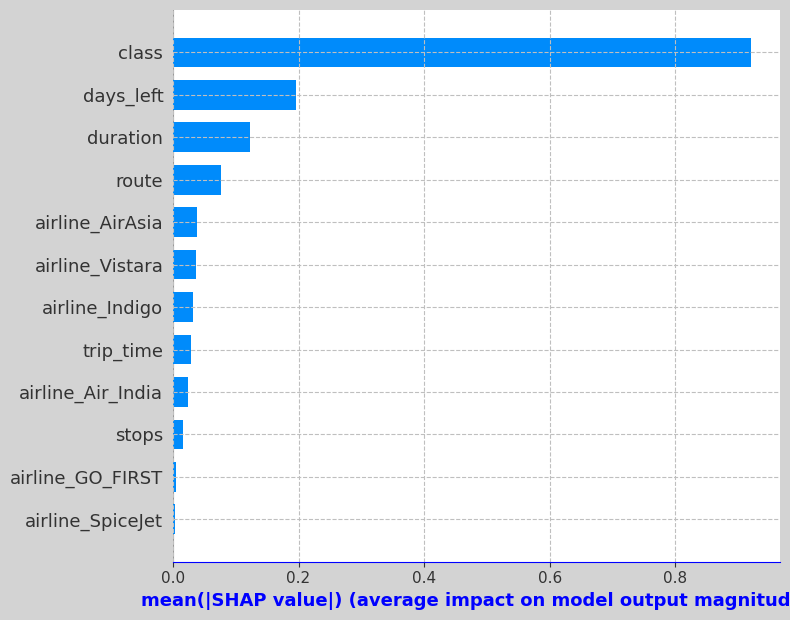

In [40]:
shap.summary_plot(shap_values, features,plot_type='bar')

In [41]:
# creating widgets for input
input_widgets = {}

style = {'description_width': '120px'}
layout = widgets.Layout(width='320px', margin='5px')

for col in orig_x_cat:
    input_widgets[col] = widgets.Dropdown(
        options=sorted(df_copy[col].unique()),
        description=col.replace('_', ' ').title(),
        style=style,
        layout=layout
    )

for col in orig_x_num:
    input_widgets[col] = widgets.FloatSlider(
        min=float(df_copy[col].min()),
        max=float(df_copy[col].max()),
        step=1.0,
        value=float(df_copy[col].mean()),
        description=col.replace('_', ' ').title(),
        style=style,
        layout=layout
    )

output = Output()


def prediction(*args):
    inputs = {name: widget.value for name, widget in input_widgets.items()}
    
    if inputs['source_city'] == inputs['destination_city']:
        with output:
            output.clear_output()
            print(f"⚠️ Error: Source and Destination cannot be the same city.")
        return

    inputs['route'] = inputs['source_city']+" - "+inputs['destination_city']
    inputs['trip_time'] = inputs['departure_time']+" - "+inputs['arrival_time']
    
    cols_to_remove = ['source_city', 'destination_city', 'departure_time', 'arrival_time']
    for col in cols_to_remove:
        if col in inputs:
            del inputs[col]
    
    df_input = pd.DataFrame([inputs])
    
    try:
        log_pred = model.predict(df_input)[0]
        real_price = np.expm1(log_pred) 

        # Designing Plotly Chart
        with output:
            output.clear_output()
            
            # quantiles for color coding based on raw data
            low_q = df_copy['price'].quantile(0.33)
            high_q = df_copy['price'].quantile(0.66)
            avg_price = df_copy['price'].mean()
            max_p = df_copy['price'].max()
            min_p = df_copy['price'].min()

            fig = go.Figure(go.Indicator(
                mode = "number+gauge+delta",
                value = real_price,
                number = {'prefix': "₹", 'font': 
                          {'size': 50}, 'valueformat': ",.0f"},
                            title = {'text': 
                                     f"<b>{inputs.get('airline', 'Flight')}Ticket Price</b><br><span style='font-size:0.6em;color:gray'>{inputs['route']}</span>", 
                                     'font': {'size': 24}},
                
                delta = {
                    'reference': avg_price, 
                    'relative': False, 
                    'position': "top",
                    'valueformat': ",.0f"
                },
                
                gauge = {
                    'axis': {'range': [min_p, max_p], 
                             'tickwidth': 1, 
                             'tickcolor': "darkblue"},
                    'bar': {'color': "darkblue"},
                    'bgcolor': "white",
                    'borderwidth': 2,
                    'bordercolor': "gray",
                    'steps': [
                        {'range': [min_p, low_q], 'color': "#2ecc71"}, 
                        {'range': [low_q, high_q], 'color': "#f1c40f"},   
                        {'range': [high_q, max_p], 'color': "#e74c3c"} 
                    ],
                    'threshold': {
                        'line': {'color': "black", 'width': 4},
                        'thickness': 0.75,
                        'value': real_price
                    }
                }
            ))
            
            fig.update_layout(height=450, width=650, margin=dict(t=80, b=10, l=30, r=30))
            fig.show()
            
    except Exception as e:
        with output:
            output.clear_output()
            print(f"❌ Prediction Error: {str(e)}")
            print("Check if the engineered feature strings ('route', 'trip_time') match your training data exactly.")


row1 = HBox([input_widgets['source_city'], input_widgets['destination_city'], input_widgets['stops']])
row2 = HBox([input_widgets['airline'], input_widgets['class']])
row3 = HBox([input_widgets['departure_time'], input_widgets['arrival_time']])
row4 = HBox([input_widgets['days_left'],  input_widgets['duration']])

ui = VBox([
    widgets.HTML("<h2>✈️ Flight Price Estimator</h2>"),
    row1, 
    row2, 
    row3,
    row4,
    widgets.HTML("<hr>") # Visual separator
])


for w in input_widgets.values():
    w.observe(prediction, names='value')

display(ui, output)

# Trigger initial calculation
prediction()

Output()

In [42]:
style = {'description_width': 'initial'}
full_width = Layout(width='95%')

input_widgets = {}

# Create widgets based on df_copy
input_widgets['source_city'] = widgets.Dropdown(
    options=sorted(df_copy['source_city'].unique()), description='🛫 Source', style=style, layout=full_width
)
input_widgets['destination_city'] = widgets.Dropdown(
    options=sorted(df_copy['destination_city'].unique()), description='🛬 Destination', style=style, layout=full_width
)
input_widgets['class'] = widgets.ToggleButtons(
    options=['Economy', 'Business'], description='Class', style={'button_width': '80px'}, layout=full_width
)
input_widgets['stops'] = widgets.SelectionSlider(
    options=['zero', 'one', 'two_or_more'], description='Stops', style=style, layout=full_width
)
# Note: We still let them pick an airline to highlight it, but we will show ALL airlines
input_widgets['airline'] = widgets.Dropdown(
    options=sorted(df_copy['airline'].unique()), description='Preferred Airline', style=style, layout=full_width
)
for col in ['departure_time', 'arrival_time']:
    input_widgets[col] = widgets.Dropdown(
        options=sorted(df_copy[col].unique()), description=col.replace('_', ' ').title(), style=style, layout=full_width
    )

input_widgets['days_left'] = widgets.IntSlider(
    min=1, max=49, step=1, value=10, description='Days Left', style=style, layout=full_width
)
input_widgets['duration'] = widgets.FloatSlider(
    min=2.0, max=30.0, step=0.5, value=10.0, description='Duration (Hrs)', style=style, layout=full_width
)

output = Output()


def prediction(change=None):
    inputs = {name: w.value for name, w in input_widgets.items()}
    
    if inputs['source_city'] == inputs['destination_city']:
        with output:
            output.clear_output()
            display(HTML("<h4 style='color:red'>⚠️ Source & Destination cannot be same.</h4>"))
        return

    #  Create a batch of data for ALL airlines 
    all_airlines = sorted(df_copy['airline'].unique())
    
    # replicate the user's inputs N times (where N is number of airlines)
    batch_data = []
    for airline in all_airlines:
        row = inputs.copy()
        row['airline'] = airline # Override with the specific airline
        
        row['route'] = row['source_city']+" - "+row['destination_city']
        row['trip_time'] = row['departure_time']+" - "+row['arrival_time']
        
        for col in ['source_city', 'destination_city', 'departure_time', 'arrival_time']:
            if col in row: del row[col]
            
        batch_data.append(row)
    
    # Create DataFrame for batch prediction
    df_batch = pd.DataFrame(batch_data)
    
    try:
        # Predict ALL airlines at once
        log_preds = model.predict(df_batch)
        real_prices = np.expm1(log_preds)
        
        # Identify the user's selected price
        user_selection_idx = all_airlines.index(inputs['airline'])
        user_price = real_prices[user_selection_idx]
        
        # --- PLOTTING ---
        with output:
            output.clear_output()
            
            # Colors: Highlight the selected airline, grey out the others
            colors = ['#bdc3c7'] * len(all_airlines) # Grey
            colors[user_selection_idx] = '#2ecc71' if user_price == min(real_prices) else '#3498db' # Green if cheapest, else Blue
            
            fig = go.Figure()
            
            # Add Bar Chart
            fig.add_trace(go.Bar(
                x=real_prices,
                y=all_airlines,
                orientation='h', # Horizontal bars read better for text labels
                marker_color=colors,
                text=[f"₹{p:,.0f}" for p in real_prices],
                textposition='auto',
                hovertemplate='<b>%{y}</b><br>Price: ₹%{x:,.0f}<extra></extra>'
            ))
            
            title_text = f"Price Comparison: <b>{inputs['airline']}</b> vs Others"
            if user_price == min(real_prices):
                subtitle = f"<span style='color:green'>Great choice! {inputs['airline']} is the cheapest option.</span>"
            else:
                cheapest_airline = all_airlines[np.argmin(real_prices)]
                diff = user_price - min(real_prices)
                subtitle = f"<span style='color:red'>Tip: {cheapest_airline} is cheaper by ₹{diff:,.0f}</span>"

            fig.update_layout(
                title={'text': f"{title_text}<br><span style='font-size:12px'>{subtitle}</span>"},
                xaxis_title="Ticket Price (₹)",
                height=450,
                margin=dict(l=10, r=10, t=60, b=10),
                template='plotly_white'
            )
            
            fig.show()
            
    except Exception as e:
        with output:
            print(f"Error: {e}")

controls = VBox([
    HTML("<h3>🎛️ Flight Controls</h3>"),
    input_widgets['source_city'], input_widgets['destination_city'],
    HTML("<hr>"),
    input_widgets['airline'], input_widgets['class'], input_widgets['stops'],
    HTML("<hr>"),
    HBox([input_widgets['arrival_time']]),
    HTML("<hr>"),
    HBox([input_widgets['departure_time']]),
    input_widgets['days_left'], input_widgets['duration']
], layout=Layout(width='350px', border='1px solid #ddd', padding='10px'))

dashboard = HBox([controls, VBox([output], layout=Layout(width='100%', padding='20px'))])

# START
for w in input_widgets.values():
    w.observe(prediction, names='value')

display(dashboard)
prediction()